In [1]:
import pandas as pd
import numpy as np
import patsy
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import sklearn.metrics as metrics
from sklearn.metrics import brier_score_loss, roc_curve, auc, confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from plotnine import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
# helper functions

def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def create_coef_matrix(X, model):
    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns),pd.DataFrame(model.coef_.flatten())], axis = 1
    )
    coef_matrix.columns = ['variable', 'coefficient']
    coef_matrix.iloc[-1] = ['Intercept', model.intercept_.flatten()[0]]
    return coef_matrix

def cv_summary(lambdas, C_values, model):
    d = {'lambdas': lambdas, 'C_values': C_values, 'mean_cv_score': model.scores_[1].mean(axis = 0)}
    return(pd.DataFrame(data=d))

def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr')) \
        + geom_line(size = 0.7) \
        + geom_area(position = 'identity', fill = 'mediumaquamarine', alpha = 0.3) \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)

def sigmoid_array(x):
    return(1 / (1 + np.exp(-x)))

def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold,param_index,:]
    return(sigmoid_array(np.dot(X, np.transpose(fold_coef)[:-1]) +  np.transpose(fold_coef)[-1]))

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy.false_pos*FP + all_coords_copy.false_neg*FN)/all_coords_copy.n
    
    t = optimal_threshold
    l = curr_exp_loss
    
    plot = ggplot(all_coords_copy, aes(x = 'thresholds', y = 'loss')) + \
        geom_line(size=0.7) + \
        coord_cartesian(xlim=(0,1))+ \
        geom_vline(xintercept = t) + \
        annotate(geom = "text", x = t - 0.01, y= max(all_coords_copy.loss) - 0.4,
                 label="best threshold: " + str(round(t,2)), angle=90, size = 7) +\
        annotate(geom = "text", x = t + 0.06, y= l,\
                 label= str(round(l, 2)), size = 7) +\
        theme_bw()
    return(plot)


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = all_coords_copy.true_neg/all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos/all_coords_copy.pos
    
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = ggplot(all_coords_copy, aes(x = 'sp', y = 'se')) +\
        geom_line(color=color[0], size=0.7) +\
        scale_y_continuous(breaks = seq(0, 1.1, by = 0.1)) +\
        scale_x_reverse(breaks = seq(0, 1.1, by = 0.1)) +\
        geom_point(data = pd.DataFrame({'sp': [sp], 'se': [se]})) +\
        annotate(geom = "text", x = sp, y = se + 0.03,
                 label = str(round(sp, 2)) + ', ' + str(round(se, 2)), size = 7) +\
        theme_bw()
    return(plot)

# Data loading, feature engineering

In [3]:
raw_data = pd.read_csv("https://osf.io/download/3qyut/")

In [4]:
raw_data.head()

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1001034.0,2005-01-01,2005-12-31,NaN,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1001034.0,2006-01-01,2006-12-31,NaN,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1001034.0,2007-01-01,2007-12-31,NaN,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1001034.0,2008-01-01,2008-12-31,NaN,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1001034.0,2009-01-01,2009-12-31,NaN,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287829 entries, 0 to 287828
Data columns (total 48 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   comp_id               287829 non-null  float64
 1   begin                 287829 non-null  object 
 2   end                   287829 non-null  object 
 3   COGS                  18257 non-null   float64
 4   amort                 279789 non-null  float64
 5   curr_assets           287698 non-null  float64
 6   curr_liab             287698 non-null  float64
 7   extra_exp             269300 non-null  float64
 8   extra_inc             269300 non-null  float64
 9   extra_profit_loss     270626 non-null  float64
 10  finished_prod         17485 non-null   float64
 11  fixed_assets          287698 non-null  float64
 12  inc_bef_tax           280392 non-null  float64
 13  intang_assets         287689 non-null  float64
 14  inventories           287698 non-null  float64
 15  

In [6]:
# dropping columns with many missing variables (COGS, finished_prod, net_dom_sales, net_exp_sales, wages, D, exit_year, exit_data)

raw_data = raw_data.drop(columns = ['COGS', 'finished_prod', 'net_dom_sales', 'net_exp_sales', 'wages', 'D', 'exit_year', 'exit_date'])

In [7]:
# adding age of firms

raw_data["age"] = np.where(
    raw_data["year"] - raw_data["founded_year"] < 0, 0, raw_data["year"] - raw_data["founded_year"])

In [8]:
# add all missing year and comp_id combinations -
# originally missing combinations will have NAs in all other columns
raw_data = (
    raw_data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
raw_data = raw_data.replace("toReplace", np.nan)

In [9]:
# generate status_alive; if sales larger than zero and not-NA, then firm is alive
raw_data["status_alive"] = (raw_data["sales"] > 0 & (False == raw_data["sales"].isna())).astype(int)

In [10]:
# defaults in 1 year if there are sales in this year but no sales one year later

raw_data["default"] = (
    (raw_data["status_alive"] == 1)
    & (raw_data.groupby("comp_id")["status_alive"].shift(-1) == 0)
).astype(int)

In [11]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556944 entries, 0 to 556943
Data columns (total 43 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  556944 non-null  int64  
 1   comp_id               556944 non-null  float64
 2   begin                 287829 non-null  object 
 3   end                   287829 non-null  object 
 4   amort                 279789 non-null  float64
 5   curr_assets           287698 non-null  float64
 6   curr_liab             287698 non-null  float64
 7   extra_exp             269300 non-null  float64
 8   extra_inc             269300 non-null  float64
 9   extra_profit_loss     270626 non-null  float64
 10  fixed_assets          287698 non-null  float64
 11  inc_bef_tax           280392 non-null  float64
 12  intang_assets         287689 non-null  float64
 13  inventories           287698 non-null  float64
 14  liq_assets            287698 non-null  float64
 15  

In [12]:
# assets can't be negative. Change them to 0 and add a flag.
raw_data["flag_asset_problem"] = np.where(
    (
        (raw_data["intang_assets"] < 0)
        | (raw_data["curr_assets"] < 0)
        | (raw_data["fixed_assets"] < 0)
    ),
    1,
    0,
)
raw_data["flag_asset_problem"] = np.where(
    (
        (raw_data["intang_assets"].isna())
        | (raw_data["curr_assets"].isna())
        | (raw_data["fixed_assets"].isna())
    ),
    np.nan,
    raw_data["flag_asset_problem"],
)
raw_data.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.0    287466
1.0       223
Name: comp_id, dtype: int64

In [13]:
# impute with 0 for asset problems

raw_data["intang_assets"] = np.where(raw_data["intang_assets"] < 0, 0, raw_data["intang_assets"])
raw_data["curr_assets"] = np.where(raw_data["curr_assets"] < 0, 0, raw_data["curr_assets"])
raw_data["fixed_assets"] = np.where(raw_data["fixed_assets"] < 0, 0, raw_data["fixed_assets"])

In [14]:
# generate total assets
raw_data["total_assets_bs"] = (
    raw_data["intang_assets"] + raw_data["curr_assets"] + raw_data["fixed_assets"]
)
round(raw_data["total_assets_bs"].describe(), 3)

count    2.876890e+05
mean     5.980575e+05
std      2.623770e+07
min      0.000000e+00
25%      4.792593e+03
50%      2.024815e+04
75%      8.810740e+04
max      1.032471e+10
Name: total_assets_bs, dtype: float64

In [15]:
# define P&L and Balance sheet column names

pl_names = ['extra_exp','extra_inc',  'extra_profit_loss', 'inc_bef_tax' ,'inventories',
              'material_exp', 'profit_loss_year', 'personnel_exp']
bs_names = ['intang_assets', 'curr_liab', 'fixed_assets', 'liq_assets', 'curr_assets',
              'share_eq', 'subscribed_cap', 'tang_assets' ]

In [16]:
# divide all pl_names elements by sales and create new column for it
raw_data[[col + "_pl" for col in pl_names]] = raw_data[pl_names].div(
    raw_data["sales"], axis="index"
)

In [17]:
# divide all bs_names elements by total_assets_bs and create new column for it
raw_data[[col + "_bs" for col in bs_names]] = (
    raw_data[bs_names]
    .div(raw_data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)

In [18]:
# imputing labor_avg and birth_year, adding flag and dropping original column - these have the highest number of missing values. 

raw_data["labor_avg_mod"] = np.where(
    raw_data["labor_avg"].isna(), raw_data["labor_avg"].mean(), raw_data["labor_avg"]
)
raw_data["flag_miss_labor_avg"] = (raw_data["labor_avg"].isna()).astype(int)
raw_data = raw_data.drop(['labor_avg'], axis=1)

raw_data["birth_year_mod"] = np.where(
    raw_data["birth_year"].isna(), raw_data["birth_year"].mean(), raw_data["birth_year"]
)
raw_data["flag_miss_birth_year"] = (raw_data["birth_year"].isna()).astype(int)
raw_data = raw_data.drop(['birth_year'], axis=1)

In [19]:
# convert to categorical where relevant

cat_vars = ["gender", "origin", "ind2", "ind", "urban_m", "region_m", "nace_main"]

for col in cat_vars:
    raw_data[col] = raw_data[col].astype("category")

In [20]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556944 entries, 0 to 556943
Data columns (total 63 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   year                  556944 non-null  int64   
 1   comp_id               556944 non-null  float64 
 2   begin                 287829 non-null  object  
 3   end                   287829 non-null  object  
 4   amort                 279789 non-null  float64 
 5   curr_assets           287698 non-null  float64 
 6   curr_liab             287698 non-null  float64 
 7   extra_exp             269300 non-null  float64 
 8   extra_inc             269300 non-null  float64 
 9   extra_profit_loss     270626 non-null  float64 
 10  fixed_assets          287698 non-null  float64 
 11  inc_bef_tax           280392 non-null  float64 
 12  intang_assets         287689 non-null  float64 
 13  inventories           287698 non-null  float64 
 14  liq_assets            287698 non-nul

In [21]:
holdout_data = raw_data[raw_data["ind2"] == 26]
holdout_data

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,fixed_assets_bs,liq_assets_bs,curr_assets_bs,share_eq_bs,subscribed_cap_bs,tang_assets_bs,labor_avg_mod,flag_miss_labor_avg,birth_year_mod,flag_miss_birth_year
156,2005,6.538183e+06,2005-01-01,2005-12-31,792.592590,6237.037109,348.148163,0.000000,0.000000,0.000000,...,0.214552,0.689366,0.785448,0.946828,0.006996,0.214552,1.009435,1,1964.902661,1
162,2005,6.934257e+06,2005-05-13,2005-12-31,803.703674,4648.147949,9311.111328,0.000000,0.000000,0.000000,...,0.718736,0.147692,0.281264,0.034738,0.672344,0.718736,1.009435,1,1964.902661,1
182,2005,8.416055e+06,2005-01-01,2005-12-31,3155.555664,71070.367188,25514.814453,74.074074,0.000000,-74.074074,...,0.151399,0.747625,0.847983,0.701843,0.132573,0.150780,1.009435,1,1960.000000,0
234,2005,1.242838e+07,2005-01-01,2005-12-31,3137.037109,1740.740723,2192.592529,0.000000,0.000000,0.000000,...,0.521212,0.450505,0.474747,0.397980,0.020202,0.517172,1.009435,1,1964.902661,1
261,2005,1.571155e+07,2005-01-01,2005-12-31,1592.592651,4740.740723,4970.370605,0.000000,7407.407227,7407.407227,...,0.171521,0.274434,0.828479,0.131392,1.941748,0.171521,1.009435,1,1964.902661,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556634,2016,4.580800e+11,2016-01-01,2016-12-31,3529.629639,125537.039062,0.000000,NaN,NaN,NaN,...,0.102048,0.316502,0.897952,0.920656,0.079477,0.102048,0.166667,0,1959.000000,0
556683,2016,4.591262e+11,2016-01-01,2016-12-31,4011.111084,58948.148438,30874.074219,NaN,NaN,NaN,...,0.232816,0.367011,0.767184,0.630146,1.332787,0.232816,0.125000,0,1964.902661,1
556789,2016,4.610112e+11,2016-01-01,2016-12-31,148.148148,67448.148438,5059.259277,NaN,NaN,NaN,...,0.042802,0.441048,0.956410,0.929626,0.157555,0.042015,0.250000,0,1959.000000,0
556842,2016,4.620594e+11,2016-01-01,2016-12-31,559.259277,64011.109375,8662.962891,NaN,NaN,NaN,...,0.000000,0.037841,1.000000,0.866111,0.173581,0.000000,0.118056,0,1953.000000,0


In [22]:
# look at cross section
holdout_data = holdout_data.query("year==2014 & status_alive == 1")
# look at firms below 10m euro revenues and above 1000 euros
holdout_data = holdout_data.query("sales<=10000000 & sales>=1000")
holdout_data

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,fixed_assets_bs,liq_assets_bs,curr_assets_bs,share_eq_bs,subscribed_cap_bs,tang_assets_bs,labor_avg_mod,flag_miss_labor_avg,birth_year_mod,flag_miss_birth_year
417864,2014,6.538183e+06,2014-01-01,2014-12-31,1018.518494,17022.222656,3040.740723,0.0,0.0,0.0,...,0.164819,0.832455,0.835181,0.850809,0.002726,0.164819,1.009435,1,1961.5,0
417890,2014,8.416055e+06,2014-01-01,2014-12-31,425.925934,105740.742188,6918.518555,0.0,0.0,0.0,...,0.067207,0.680041,0.932793,0.945372,0.098017,0.067207,0.083333,0,1960.0,0
417942,2014,1.242838e+07,2014-01-01,2014-12-31,0.000000,0.000000,9277.777344,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0,1962.0,0
417989,2014,1.777654e+07,2014-01-01,2014-12-31,48.148148,142296.296875,164237.031250,0.0,0.0,0.0,...,0.510834,0.007804,0.403525,0.406907,0.136539,0.425192,0.305556,0,1970.5,0
417994,2014,1.862676e+07,2014-01-01,2014-12-31,5755.555664,95185.187500,45766.667969,0.0,0.0,0.0,...,0.193371,0.094661,0.806629,0.611594,0.015693,0.193371,0.159091,0,1978.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463875,2014,4.593723e+11,2014-01-01,2014-12-31,0.000000,40740.742188,559.259277,0.0,0.0,0.0,...,0.000000,0.943727,1.000000,0.986273,0.023000,0.000000,0.083333,0,1975.0,0
463965,2014,4.610112e+11,2014-01-01,2014-12-31,429.629639,58781.480469,2651.851807,0.0,0.0,0.0,...,0.055866,0.637822,0.943243,0.957387,0.178296,0.054974,0.166667,0,1959.0,0
464018,2014,4.620594e+11,2014-01-01,2014-12-31,1111.111084,68274.070312,16211.111328,0.0,0.0,0.0,...,0.011635,0.024288,0.988365,0.765321,0.160849,0.011635,0.250000,0,1953.0,0
464032,2014,4.623300e+11,2014-01-01,2014-12-31,0.000000,17192.591797,7325.925781,0.0,0.0,0.0,...,0.375656,0.368796,0.624344,0.654472,0.672495,0.375656,0.166667,0,1961.5,0


In [23]:
round(holdout_data.sales.describe(), 3)

count       1037.000
mean      490202.218
std      1154087.414
min         1070.370
25%        21766.666
50%        72700.000
75%       333888.875
max      9576485.000
Name: sales, dtype: float64

In [24]:
holdout_data.default.value_counts()

default
0    981
1     56
Name: count, dtype: int64

The holdout_data now contains the right dataset (1037 observations, 56 defaults, correct sales figures).

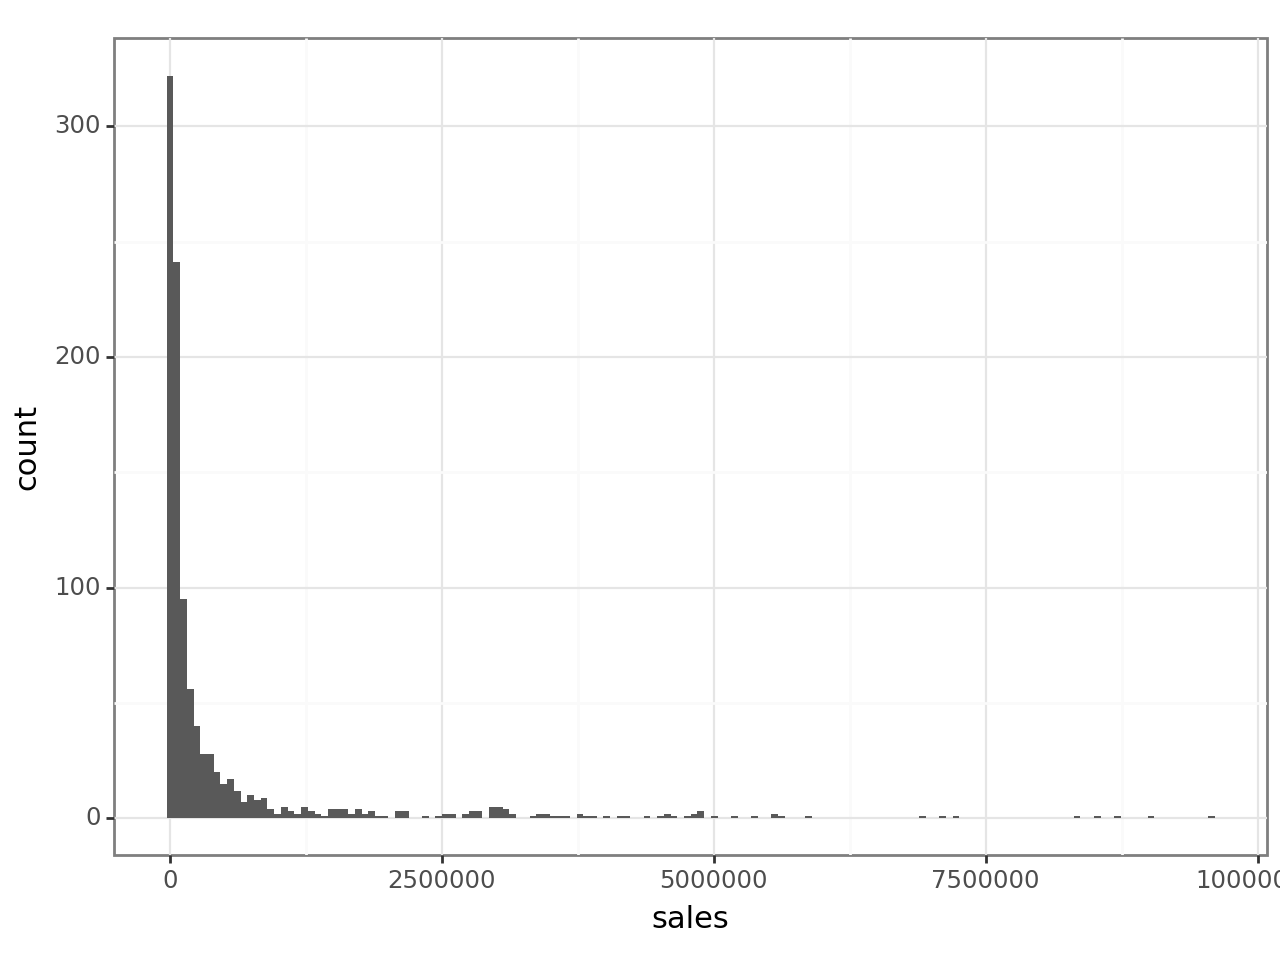

<Figure Size: (640 x 480)>

In [25]:
ggplot(holdout_data, aes("sales")) + geom_histogram() + theme_bw()

Most companies' sales are below 1M EUR in the holdout data.

In [26]:
holdout_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1037 entries, 417864 to 464055
Data columns (total 63 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   year                  1037 non-null   int64   
 1   comp_id               1037 non-null   float64 
 2   begin                 1037 non-null   object  
 3   end                   1037 non-null   object  
 4   amort                 1035 non-null   float64 
 5   curr_assets           1037 non-null   float64 
 6   curr_liab             1037 non-null   float64 
 7   extra_exp             1037 non-null   float64 
 8   extra_inc             1037 non-null   float64 
 9   extra_profit_loss     1037 non-null   float64 
 10  fixed_assets          1037 non-null   float64 
 11  inc_bef_tax           1037 non-null   float64 
 12  intang_assets         1037 non-null   float64 
 13  inventories           1037 non-null   float64 
 14  liq_assets            1037 non-null   float64 
 15  ma

The different training datasets will be taken from the `raw_data` DataFrame based on some criteria. 

In [27]:
# data1 will be the same industry with the same sales figure restrictions, just one year before - this will be a relatively small dataset.

data1 = raw_data.query("year==2013 & status_alive == 1")
data1 = data1.query("sales<=10000000 & sales>=1000 & ind2 == 26")
data1.shape

(1050, 63)

In [28]:
data1.default.value_counts()

default
0    999
1     51
Name: count, dtype: int64

In [29]:
round(data1.sales.describe(), 3)

count       1050.000
mean      465587.543
std      1173668.081
min         1000.000
25%        21786.112
50%        70418.516
75%       283219.438
max      9811389.000
Name: sales, dtype: float64

This dataset has very similar number of defaults as our holdout dataset, although its mean sales are a bit lower. It is likely to be quite similar to it in other features too, althoug it is quite a small dataset (only 1050 observations).

In [30]:
# data2 will include all industries (except the target) with the same sales figure restrictions, from the same year as our holdout data.

data2 = raw_data.query("year==2014 & status_alive == 1")
data2 = data2.query("sales<=10000000 & sales>=1000 & ind2 != 26")
data2.shape

(20253, 63)

In [31]:
data2.default.value_counts()

default
0    18177
1     2076
Name: count, dtype: int64

The default rate is higher than in the holdout set (around 10% vs 5%) but it is a much bigger sample.

In [32]:
round(data2.sales.describe(), 3)

count      20253.000
mean      255986.021
std       806844.236
min         1000.000
25%        17407.408
50%        50481.480
75%       157407.406
max      9963926.000
Name: sales, dtype: float64

Average sales are significantly lower than in the holdout set (256k vs 490k).

In [33]:
# data3 will include the same industry but one year earlier and with an even narrower sales filter - 
# given that most of the companies in the holdout data have less than 1M EUR sales, this filter will be applied here.

data3 = raw_data.query("year==2013 & status_alive == 1")
data3 = data3.query("sales<=1000000 & sales>=1000 & ind2 == 26")
data3.shape

(936, 63)

In [34]:
round(data3.sales.describe(), 3)

count       936.000
mean     138134.962
std      196431.376
min        1000.000
25%       18987.037
50%       51279.631
75%      165606.488
max      986803.688
Name: sales, dtype: float64

In [35]:
data3.default.value_counts()

default
0    887
1     49
Name: count, dtype: int64

In [36]:
to_filter=data1.isna().sum()
to_filter[to_filter>0]

amort                2
material_exp         2
personnel_exp        2
founded_year        92
ceo_count           92
foreign             92
female              92
inoffice_days       92
gender              92
origin              92
region_m             2
age                 92
material_exp_pl      2
personnel_exp_pl     2
dtype: int64

In [37]:
to_filter=data2.isna().sum()
to_filter[to_filter>0]

amort                    29
curr_assets              12
curr_liab                12
fixed_assets             12
intang_assets            12
inventories              12
liq_assets               12
material_exp             29
personnel_exp            29
profit_loss_year         12
share_eq                 12
subscribed_cap           12
tang_assets              12
founded_year           1056
ceo_count              1055
foreign                1055
female                 1055
inoffice_days          1055
gender                 1055
origin                 1055
nace_main                 5
ind2                      5
ind                     637
region_m                 58
founded_date              1
age                    1056
flag_asset_problem       12
total_assets_bs          12
inventories_pl           12
material_exp_pl          29
profit_loss_year_pl      12
personnel_exp_pl         29
dtype: int64

In [38]:
to_filter=data3.isna().sum()
to_filter[to_filter>0]

amort                1
material_exp         1
personnel_exp        1
founded_year        86
ceo_count           86
foreign             86
female              86
inoffice_days       86
gender              86
origin              86
age                 86
material_exp_pl      1
personnel_exp_pl     1
dtype: int64

Missing values will be dropped in data1-2-3. This will decrease the size of the datasets, but will retain only "clean" observations.
To retain the full 1037 observations in the holdout data, there all missing values will be imputed (with mean for numerical, and mode for categorical variables). Flags are to be added for all imputations.

In [39]:
to_filter=data1.isna().sum()
to_filter[to_filter>0]
data1.dropna(subset=to_filter[to_filter>0].index, inplace = True)

In [40]:
to_filter=data2.isna().sum()
to_filter[to_filter>0]
data2.dropna(subset=to_filter[to_filter>0].index, inplace = True)

In [41]:
to_filter=data3.isna().sum()
to_filter[to_filter>0]
data3.dropna(subset=to_filter[to_filter>0].index, inplace = True)

In [42]:
to_filter=holdout_data.isna().sum()
to_filter[to_filter>0]

amort                2
material_exp         2
personnel_exp        2
founded_year        31
ceo_count           31
foreign             31
female              31
inoffice_days       31
gender              31
origin              31
region_m             2
age                 31
material_exp_pl      2
personnel_exp_pl     2
dtype: int64

In [43]:
# Let's check how much the sales and default figures have changed due to dropping the NA values

round(data1.sales.describe(), 3)

count        955.000
mean      461643.749
std      1146901.911
min         1000.000
25%        21851.852
50%        72066.664
75%       289164.828
max      9811389.000
Name: sales, dtype: float64

In [44]:
round(data2.sales.describe(), 3)

count      18508.000
mean      254143.352
std       793106.390
min         1000.000
25%        17877.777
50%        51572.223
75%       159723.145
max      9963926.000
Name: sales, dtype: float64

In [45]:
round(data3.sales.describe(), 3)

count       849.000
mean     138906.431
std      196094.571
min        1000.000
25%       18988.889
50%       51481.480
75%      167270.375
max      986803.688
Name: sales, dtype: float64

In [46]:
data1.default.value_counts()

default
0    909
1     46
Name: count, dtype: int64

In [47]:
data2.default.value_counts()

default
0    16659
1     1849
Name: count, dtype: int64

In [48]:
data3.default.value_counts()

default
0    805
1     44
Name: count, dtype: int64

No major change to sales and default ratios.

In [49]:
# defining functions to impute

def impute_num(data, column):
    data["flag_"+ column] = (data[column].isna()).astype(int)
    data[column] = np.where (
        data[column].isna(), data[column].mean(), data[column]
    )
    

def impute_cat(data, column):
    data["flag_"+ column] = (data[column].isna()).astype(int)  
    data[column] = np.where (
        data[column].isna(), data[column].mode(), data[column]
    )
    
impute_num_list = ["amort", "material_exp", "personnel_exp", "founded_year", "ceo_count", "foreign", "female", "inoffice_days", "age"]
impute_cat_list = ["gender", "origin", "region_m"]

The datasets will be created in the following way: the holdout set and the different training sets will be merged pairwise. Later for the anaylses, we will be able to separate them based on their indexing. All NaN values can be replaced with 0, as there were no imputations in data1, data2 and data3.

In [50]:
dataset1 = pd.concat([data1, holdout_data])
dataset1

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,fixed_assets_bs,liq_assets_bs,curr_assets_bs,share_eq_bs,subscribed_cap_bs,tang_assets_bs,labor_avg_mod,flag_miss_labor_avg,birth_year_mod,flag_miss_birth_year
371478,2013,8.416055e+06,2013-01-01,2013-12-31,266.666656,106448.148438,4674.074219,0.000000,0.0,0.000000,...,0.068816,0.755030,0.931184,0.964490,0.097197,0.068816,0.083333,0,1960.0,0
371577,2013,1.777654e+07,2013-01-01,2013-12-31,34155.554688,61011.109375,79103.703125,0.000000,0.0,0.000000,...,0.662866,0.027037,0.225509,0.516961,0.177965,0.551240,0.180556,0,1970.5,0
371582,2013,1.862676e+07,2013-01-01,2013-12-31,1518.518555,101422.218750,38200.000000,951.851868,0.0,-951.851868,...,0.037029,0.320568,0.962971,0.625734,0.017583,0.037029,0.152778,0,1978.0,0
371697,2013,3.447888e+07,2013-01-01,2013-12-31,333.333344,3940.740723,3129.629639,0.000000,0.0,0.000000,...,0.371984,0.053561,0.626251,0.520895,0.294291,0.370218,0.083333,0,1956.0,0
371709,2013,3.648780e+07,2013-01-01,2013-12-31,351.851837,5837.037109,2129.629639,0.000000,0.0,0.000000,...,0.000000,0.607868,1.000000,0.579315,0.317259,0.000000,1.009435,1,1979.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463875,2014,4.593723e+11,2014-01-01,2014-12-31,0.000000,40740.742188,559.259277,0.000000,0.0,0.000000,...,0.000000,0.943727,1.000000,0.986273,0.023000,0.000000,0.083333,0,1975.0,0
463965,2014,4.610112e+11,2014-01-01,2014-12-31,429.629639,58781.480469,2651.851807,0.000000,0.0,0.000000,...,0.055866,0.637822,0.943243,0.957387,0.178296,0.054974,0.166667,0,1959.0,0
464018,2014,4.620594e+11,2014-01-01,2014-12-31,1111.111084,68274.070312,16211.111328,0.000000,0.0,0.000000,...,0.011635,0.024288,0.988365,0.765321,0.160849,0.011635,0.250000,0,1953.0,0
464032,2014,4.623300e+11,2014-01-01,2014-12-31,0.000000,17192.591797,7325.925781,0.000000,0.0,0.000000,...,0.375656,0.368796,0.624344,0.654472,0.672495,0.375656,0.166667,0,1961.5,0


In [51]:
dataset1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1992 entries, 371478 to 464055
Data columns (total 63 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   year                  1992 non-null   int64   
 1   comp_id               1992 non-null   float64 
 2   begin                 1992 non-null   object  
 3   end                   1992 non-null   object  
 4   amort                 1990 non-null   float64 
 5   curr_assets           1992 non-null   float64 
 6   curr_liab             1992 non-null   float64 
 7   extra_exp             1992 non-null   float64 
 8   extra_inc             1992 non-null   float64 
 9   extra_profit_loss     1992 non-null   float64 
 10  fixed_assets          1992 non-null   float64 
 11  inc_bef_tax           1992 non-null   float64 
 12  intang_assets         1992 non-null   float64 
 13  inventories           1992 non-null   float64 
 14  liq_assets            1992 non-null   float64 
 15  ma

In [52]:
for col in impute_num_list:
    impute_num(dataset1, col)

for col in impute_cat_list:
    impute_cat(dataset1, col)
    
to_filter=dataset1.isna().sum()
to_filter[to_filter>0]

material_exp_pl     2
personnel_exp_pl    2
dtype: int64

In [53]:
dataset1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1992 entries, 371478 to 464055
Data columns (total 75 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   year                  1992 non-null   int64   
 1   comp_id               1992 non-null   float64 
 2   begin                 1992 non-null   object  
 3   end                   1992 non-null   object  
 4   amort                 1992 non-null   float64 
 5   curr_assets           1992 non-null   float64 
 6   curr_liab             1992 non-null   float64 
 7   extra_exp             1992 non-null   float64 
 8   extra_inc             1992 non-null   float64 
 9   extra_profit_loss     1992 non-null   float64 
 10  fixed_assets          1992 non-null   float64 
 11  inc_bef_tax           1992 non-null   float64 
 12  intang_assets         1992 non-null   float64 
 13  inventories           1992 non-null   float64 
 14  liq_assets            1992 non-null   float64 
 15  ma

In [54]:
# recalculate missing values for _pl variables, and rename columns
pl_names2 = ["material_exp", "personnel_exp"]
dataset1[[col + "_pl" for col in pl_names2]] = dataset1[pl_names2].div(
    dataset1["sales"], axis="index")

In [55]:
dataset1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1992 entries, 371478 to 464055
Data columns (total 75 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   year                  1992 non-null   int64   
 1   comp_id               1992 non-null   float64 
 2   begin                 1992 non-null   object  
 3   end                   1992 non-null   object  
 4   amort                 1992 non-null   float64 
 5   curr_assets           1992 non-null   float64 
 6   curr_liab             1992 non-null   float64 
 7   extra_exp             1992 non-null   float64 
 8   extra_inc             1992 non-null   float64 
 9   extra_profit_loss     1992 non-null   float64 
 10  fixed_assets          1992 non-null   float64 
 11  inc_bef_tax           1992 non-null   float64 
 12  intang_assets         1992 non-null   float64 
 13  inventories           1992 non-null   float64 
 14  liq_assets            1992 non-null   float64 
 15  ma

In [56]:
dataset2 = pd.concat([data2, holdout_data])
dataset2

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,fixed_assets_bs,liq_assets_bs,curr_assets_bs,share_eq_bs,subscribed_cap_bs,tang_assets_bs,labor_avg_mod,flag_miss_labor_avg,birth_year_mod,flag_miss_birth_year
417709,2014,1.001541e+06,2014-01-01,2014-12-31,2292.592529,6500.000000,296.296295,0.0,0.0,0.0,...,0.966231,0.030729,0.033769,0.998461,1.042909,0.966231,1.009435,1,1962.5,0
417710,2014,1.002029e+06,2014-01-01,2014-12-31,17918.517578,183677.781250,59433.332031,0.0,0.0,0.0,...,0.226644,0.047858,0.773356,0.595256,0.046782,0.226644,0.305556,0,1979.0,0
417715,2014,1.011889e+06,2014-01-01,2014-12-31,46214.816406,281681.468750,9622.222656,0.0,0.0,0.0,...,0.774744,0.196807,0.224612,0.988842,0.013940,0.774100,1.465278,0,1946.0,0
417716,2014,1.014183e+06,2014-01-01,2014-12-31,6403.703613,217033.328125,6362.962891,0.0,0.0,0.0,...,0.332258,0.138895,0.667742,0.980514,0.034185,0.332258,0.847222,0,1946.0,0
417717,2014,1.018301e+06,2014-01-01,2014-12-31,0.000000,1759.259277,1544.444458,0.0,0.0,0.0,...,0.965578,0.009573,0.032249,0.188743,0.203680,0.963406,0.166667,0,1960.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463875,2014,4.593723e+11,2014-01-01,2014-12-31,0.000000,40740.742188,559.259277,0.0,0.0,0.0,...,0.000000,0.943727,1.000000,0.986273,0.023000,0.000000,0.083333,0,1975.0,0
463965,2014,4.610112e+11,2014-01-01,2014-12-31,429.629639,58781.480469,2651.851807,0.0,0.0,0.0,...,0.055866,0.637822,0.943243,0.957387,0.178296,0.054974,0.166667,0,1959.0,0
464018,2014,4.620594e+11,2014-01-01,2014-12-31,1111.111084,68274.070312,16211.111328,0.0,0.0,0.0,...,0.011635,0.024288,0.988365,0.765321,0.160849,0.011635,0.250000,0,1953.0,0
464032,2014,4.623300e+11,2014-01-01,2014-12-31,0.000000,17192.591797,7325.925781,0.0,0.0,0.0,...,0.375656,0.368796,0.624344,0.654472,0.672495,0.375656,0.166667,0,1961.5,0


In [57]:
for col in impute_num_list:
    impute_num(dataset2, col)

for col in impute_cat_list:
    impute_cat(dataset2, col)
    
to_filter=dataset2.isna().sum()
to_filter[to_filter>0]

material_exp_pl     2
personnel_exp_pl    2
dtype: int64

In [58]:
# recalculate missing values for _pl variables, and rename columns
pl_names2 = ["material_exp", "personnel_exp"]
dataset2[[col + "_pl" for col in pl_names2]] = dataset2[pl_names2].div(
    dataset2["sales"], axis="index")

In [59]:
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19545 entries, 417709 to 464055
Data columns (total 75 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   year                  19545 non-null  int64   
 1   comp_id               19545 non-null  float64 
 2   begin                 19545 non-null  object  
 3   end                   19545 non-null  object  
 4   amort                 19545 non-null  float64 
 5   curr_assets           19545 non-null  float64 
 6   curr_liab             19545 non-null  float64 
 7   extra_exp             19545 non-null  float64 
 8   extra_inc             19545 non-null  float64 
 9   extra_profit_loss     19545 non-null  float64 
 10  fixed_assets          19545 non-null  float64 
 11  inc_bef_tax           19545 non-null  float64 
 12  intang_assets         19545 non-null  float64 
 13  inventories           19545 non-null  float64 
 14  liq_assets            19545 non-null  float64 
 15  m

In [60]:
dataset3 = pd.concat([data3, holdout_data])
dataset3

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,fixed_assets_bs,liq_assets_bs,curr_assets_bs,share_eq_bs,subscribed_cap_bs,tang_assets_bs,labor_avg_mod,flag_miss_labor_avg,birth_year_mod,flag_miss_birth_year
371478,2013,8.416055e+06,2013-01-01,2013-12-31,266.666656,106448.148438,4674.074219,0.000000,0.0,0.000000,...,0.068816,0.755030,0.931184,0.964490,0.097197,0.068816,0.083333,0,1960.0,0
371577,2013,1.777654e+07,2013-01-01,2013-12-31,34155.554688,61011.109375,79103.703125,0.000000,0.0,0.000000,...,0.662866,0.027037,0.225509,0.516961,0.177965,0.551240,0.180556,0,1970.5,0
371582,2013,1.862676e+07,2013-01-01,2013-12-31,1518.518555,101422.218750,38200.000000,951.851868,0.0,-951.851868,...,0.037029,0.320568,0.962971,0.625734,0.017583,0.037029,0.152778,0,1978.0,0
371697,2013,3.447888e+07,2013-01-01,2013-12-31,333.333344,3940.740723,3129.629639,0.000000,0.0,0.000000,...,0.371984,0.053561,0.626251,0.520895,0.294291,0.370218,0.083333,0,1956.0,0
371709,2013,3.648780e+07,2013-01-01,2013-12-31,351.851837,5837.037109,2129.629639,0.000000,0.0,0.000000,...,0.000000,0.607868,1.000000,0.579315,0.317259,0.000000,1.009435,1,1979.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463875,2014,4.593723e+11,2014-01-01,2014-12-31,0.000000,40740.742188,559.259277,0.000000,0.0,0.000000,...,0.000000,0.943727,1.000000,0.986273,0.023000,0.000000,0.083333,0,1975.0,0
463965,2014,4.610112e+11,2014-01-01,2014-12-31,429.629639,58781.480469,2651.851807,0.000000,0.0,0.000000,...,0.055866,0.637822,0.943243,0.957387,0.178296,0.054974,0.166667,0,1959.0,0
464018,2014,4.620594e+11,2014-01-01,2014-12-31,1111.111084,68274.070312,16211.111328,0.000000,0.0,0.000000,...,0.011635,0.024288,0.988365,0.765321,0.160849,0.011635,0.250000,0,1953.0,0
464032,2014,4.623300e+11,2014-01-01,2014-12-31,0.000000,17192.591797,7325.925781,0.000000,0.0,0.000000,...,0.375656,0.368796,0.624344,0.654472,0.672495,0.375656,0.166667,0,1961.5,0


In [61]:
for col in impute_num_list:
    impute_num(dataset3, col)

for col in impute_cat_list:
    impute_cat(dataset3, col)
    
to_filter=dataset3.isna().sum()
to_filter[to_filter>0]

material_exp_pl     2
personnel_exp_pl    2
dtype: int64

In [62]:
# recalculate missing values for _pl variables, and rename columns
pl_names2 = ["material_exp", "personnel_exp"]
dataset3[[col + "_pl" for col in pl_names2]] = dataset3[pl_names2].div(
    dataset3["sales"], axis="index")

In [63]:
dataset3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1886 entries, 371478 to 464055
Data columns (total 75 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   year                  1886 non-null   int64   
 1   comp_id               1886 non-null   float64 
 2   begin                 1886 non-null   object  
 3   end                   1886 non-null   object  
 4   amort                 1886 non-null   float64 
 5   curr_assets           1886 non-null   float64 
 6   curr_liab             1886 non-null   float64 
 7   extra_exp             1886 non-null   float64 
 8   extra_inc             1886 non-null   float64 
 9   extra_profit_loss     1886 non-null   float64 
 10  fixed_assets          1886 non-null   float64 
 11  inc_bef_tax           1886 non-null   float64 
 12  intang_assets         1886 non-null   float64 
 13  inventories           1886 non-null   float64 
 14  liq_assets            1886 non-null   float64 
 15  ma

# Modeling
## Defining variable sets

There are number of feature sets that we can define: raw company-related features, P&L (as % of sales) and BS related (as % of total assets) and HR-related. Plus the categorical features.

In [64]:
raw_vars = ["curr_assets", "curr_liab", "extra_exp", "extra_inc", "extra_profit_loss", "fixed_assets",
              "inc_bef_tax", "intang_assets", "inventories", "liq_assets", "material_exp", "personnel_exp", 
            "profit_loss_year", "sales", "share_eq", "subscribed_cap", "age", "balsheet_flag", "balsheet_length", "balsheet_notfullyear", "flag_asset_problem"]

fin_vars = ["total_assets_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs",
            "share_eq_bs", "subscribed_cap_bs", "tang_assets_bs", "intang_assets_bs", "extra_exp_pl",
            "extra_inc_pl", "extra_profit_loss_pl", "inc_bef_tax_pl", "inventories_pl",
            "material_exp_pl", "profit_loss_year_pl", "personnel_exp_pl"]

hr_vars = ["female", "ceo_count", "foreign", "inoffice_days", "labor_avg_mod",
        "flag_miss_labor_avg", "birth_year_mod", "flag_miss_birth_year"]

cat_vars = ["gender", "origin", "ind2", "ind", "urban_m", "region_m"]

In [65]:
# despite dataset1 and dataset3 not containing different ind2 values, this matrix will be created as this is a relevan variable for dataset2.

dataset1.ind2.value_counts()

ind2
26.0    1992
1.0        0
69.0       0
74.0       0
73.0       0
        ... 
45.0       0
46.0       0
47.0       0
49.0       0
96.0       0
Name: count, Length: 68, dtype: int64

In [66]:
ind2_catmat = patsy.dmatrix("0 + C(ind2)",dataset1, return_type="dataframe")
ind2_catmat = ind2_catmat.drop(['C(ind2)[1.0]'], axis=1)

In [67]:
ind_catmat = patsy.dmatrix("0 + C(ind)",dataset1, return_type="dataframe")
ind_catmat = ind_catmat.drop(['C(ind)[1.0]'], axis=1)

In [68]:
m_region_locmat = patsy.dmatrix("0 + C(region_m)",dataset1, return_type="dataframe")
m_region_locmat = m_region_locmat.drop(['C(region_m)[Central]'], axis=1)

In [69]:
urban_mmat = patsy.dmatrix("0 + C(urban_m)",dataset1, return_type="dataframe")
urban_mmat = urban_mmat.drop(['C(urban_m)[1.0]'], axis=1)

In [70]:
dataset1.gender

371478    female
371577       mix
371582      male
371697    female
371709       mix
           ...  
463875      male
463965      male
464018      male
464032      male
464055      male
Name: gender, Length: 1992, dtype: object

In [71]:
gender_catmat = patsy.dmatrix("0 + C(gender)",dataset1, return_type="dataframe")
gender_catmat = gender_catmat.drop(['C(gender)[male]'], axis=1)

In [72]:
dataset1.origin

371478    Domestic
371577    Domestic
371582    Domestic
371697    Domestic
371709    Domestic
            ...   
463875    Domestic
463965    Domestic
464018    Domestic
464032         mix
464055    Domestic
Name: origin, Length: 1992, dtype: object

In [73]:
origin_catmat = patsy.dmatrix("0 + C(origin)",dataset1, return_type="dataframe")
origin_catmat = origin_catmat.drop(['C(origin)[Domestic]'], axis=1)

## Modeling on data1

3 logistics regression models are to be created: one with only the raw and financial variables, another with categorical variables added, and a third with all HR variables added. 5-fold cross validation is to be applied. On top, a random forest model is to be created as well.

In [74]:
raw = dataset1[raw_vars]
fin = dataset1[fin_vars]
X1 = pd.concat([raw, fin], axis=1)

In [75]:
X2 = pd.concat([X1, ind2_catmat, ind_catmat, m_region_locmat, urban_mmat, gender_catmat, origin_catmat], axis=1)

In [76]:
hr = dataset1[hr_vars]
X3 = pd.concat([X1, X2, hr], axis = 1)

In [77]:
rfvars  = pd.concat([X1, X2, hr], axis=1)

In [78]:
y = dataset1['default']

In [79]:
# definint train-holdout split based on dataset1's setup

index_train = data1.index
index_holdout = holdout_data.index

y_train = y.loc[index_train]
y_holdout = y.loc[index_holdout]

In [80]:
# specifying cross-validation 
k = KFold(n_splits = 5, shuffle = True, random_state = 20240224)

In [81]:
# no regularisation needed so setting the paremeter to very high value
Cs_value_logit = [1e20]

In [82]:
logit_model_vars = [X1.loc[index_train], X2.loc[index_train], X3.loc[index_train]]

logit_models = dict()
CV_RMSE_folds = dict()

In [83]:
%%time
for i in range(len(logit_model_vars)):
    LRCV_brier = LogisticRegressionCV(
        Cs=Cs_value_logit, 
        cv=k,
        refit=True, 
        scoring='neg_brier_score', 
        solver="newton-cg", 
        tol=1e-7, 
        random_state=20240224)
    logit_models['X'+str(i+1)] = LRCV_brier.fit(logit_model_vars[i], y_train)
    
    # Calculate RMSE on test for each fold
    CV_RMSE_folds['X'+str(i+1)] = np.sqrt(-1*(logit_models['X'+str(i+1)].scores_[1])).flatten()

CPU times: total: 2.81 s
Wall time: 2.85 s


In [84]:
pd.DataFrame(CV_RMSE_folds)

,X1,X2,X3
0,0.216860,0.217515,0.226688
1,0.251325,0.251325,0.203552
2,0.228664,0.228271,0.240062
3,0.244099,0.244010,0.254293
4,0.276164,0.276164,0.256437


In [85]:
# checking AUC scores as well
CV_AUC_folds = dict()

for i in range(len(logit_model_vars)):
    LRCV_auc = LogisticRegressionCV(
        Cs=Cs_value_logit, 
        cv=k, 
        refit=True, 
        scoring='roc_auc', 
        solver="newton-cg", 
        tol=1e-7, 
        random_state = 20240205)
    LRCV_auc_fit = LRCV_auc.fit(logit_model_vars[i], y_train)
    # Calculate AUC on test for each fold
    CV_AUC_folds['X'+str(i+1)] = LRCV_auc_fit.scores_[1][:,0].tolist()

In [86]:
pd.DataFrame(CV_AUC_folds)

,X1,X2,X3
0,0.747475,0.741414,0.723737
1,0.482883,0.482883,0.580180
2,0.561661,0.600122,0.731990
3,0.626263,0.625253,0.758586
4,0.661783,0.661783,0.623932


In [87]:
CV_RMSE = dict()
CV_AUC = dict()

for key in logit_models:
    CV_RMSE[key] = np.mean(CV_RMSE_folds[key])
    CV_AUC[key] = np.mean(CV_AUC_folds[key])  

logit_summary1 = np.transpose(pd.DataFrame.from_dict([CV_RMSE,CV_AUC], orient='columns'))
logit_summary1.columns = ['CV RMSE', 'CV AUC']

In [88]:
logit_summary1

,CV RMSE,CV AUC
X1,0.243423,0.616013
X2,0.243457,0.622291
X3,0.236206,0.683685


In dataset1, both with RMSE and AUC the best performing model is X3 - which is the most complex one. 

In [89]:
best_model = logit_models['X3']
best_model_X_holdout = X3.loc[index_holdout]

logit_predicted_probabilities_holdout = best_model.predict_proba(best_model_X_holdout)[:,1]
best_rmse_holdout = np.sqrt(metrics.mean_squared_error(y_holdout, logit_predicted_probabilities_holdout))
round(best_rmse_holdout, 3)

0.237

In [90]:
logit_predicted_probabilities_holdout

array([0.11287221, 0.0174075 , 0.2947131 , ..., 0.07919411, 0.05906603,
       0.04611049])

**Discrete ROC (with thresholds in steps) on holdout**

In [91]:
thresholds = [i/100 for i in range(1,80,1)]
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(logit_predicted_probabilities_holdout < thr, 0, 1)
    cm_thr = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp/(tp+fn))
    false_positive_rates.append(fp/(fp+tn))

In [92]:
cm_thr

array([[973,   8],
       [ 54,   2]], dtype=int64)

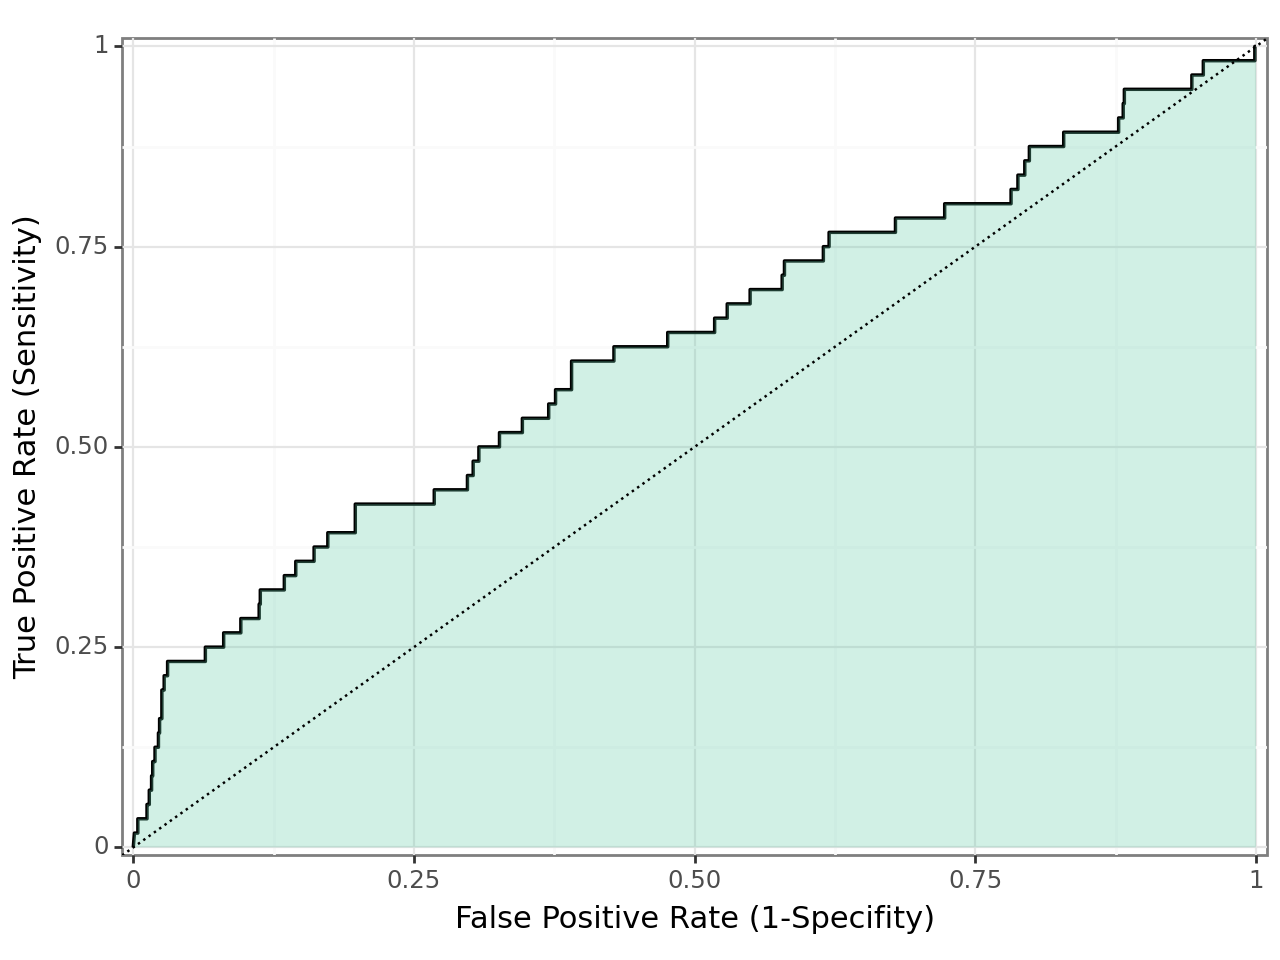

<Figure Size: (640 x 480)>

In [93]:
create_roc_plot(y_holdout, logit_predicted_probabilities_holdout)

The ROC curve shows that the model is just barely above the 45 degree line suggesting that this is still not a very good model - despite being the "best" from the created ones.

### Using the loss function to define optimal threshold

In [94]:
FP = 3
FN = 15
cost = FN/FP

# the prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))
prevelance = y_train.sum()/len(y_train)
prevelance

0.048167539267015703

In [95]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss =[]
    if model_name != 'LASSO':
        X = logit_model_vars[i]
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index,:]
        y_fold = y_train.iloc[test_index]
        pred_fold = generate_fold_prediction(logit_models[model_name], X_fold, fold, c_index)
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(list(zip(
            np.abs(true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)),\
                                       thresholds)), key=lambda i: i[0], reverse=True)[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
        curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold+1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame({
        'false_pos': false_pos_rate*sum(y_fold == 0),
        'true_pos': true_pos_rate*sum(y_fold == 1),
        'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
        'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
        'pos': sum(y_fold == 1),
        'neg': sum(y_fold == 0),
        'n': len(y_fold),
        'thresholds': thresholds
    })
    
    fold5_all_coords[model_name] = all_coords

In [96]:
expected_loss_cv

{'X1': 0.6565445026178011, 'X2': 0.6565445026178011, 'X3': 0.5874345549738219}

In [97]:
logit_summary2 = pd.DataFrame(best_thresholds_cv.items(),columns=['Model', 'Avg of optimal thresholds'])
logit_summary2['Threshold for Fold5'] = fold5_threshold.values()
logit_summary2['Avg expected loss'] = expected_loss_cv.values()
logit_summary2['Expected loss for Fold5'] = fold5_expected_loss.values()
logit_summary2

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,X1,inf,0.470899,0.656545,0.659686
1,X2,inf,0.470899,0.656545,0.659686
2,X3,0.237653,0.385103,0.587435,0.534031


The average expected loss of model X3 is 0.587 with a threshold of 0.238.

In [98]:
best_logit_optimal_treshold = best_thresholds_cv["X3"]
best_logit_optimal_treshold

0.23765278995397657

In [99]:
holdout_treshold = np.where(logit_predicted_probabilities_holdout < best_logit_optimal_treshold, 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]).ravel()
expected_loss_holdout_log1 = (fp*FP + fn*FN)/len(y_holdout)
round(expected_loss_holdout_log1, 3)

0.749

In [100]:
cm_object3 = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1])
cm3 = pd.DataFrame(cm_object3, 
    index=['Actul no defaul', 'Actual default'], 
    columns=['Predicted no default', 'Predicted default'])
cm3

,Predicted no default,Predicted default
Actul no defaul,957,24
Actual default,47,9


### Random forest

In [101]:
rfvars_train = rfvars.loc[index_train]
rfvars_holdout = rfvars.loc[index_holdout]

In [102]:
grid = {'max_features': [5, 6, 7],
        'criterion':['gini'],
        'min_samples_split': [11, 16]}

In [103]:
prob_forest = RandomForestClassifier(
    random_state=20240224, 
    n_estimators=500, 
    oob_score=True)

prob_forest_grid = GridSearchCV(
    prob_forest, 
    grid, 
    cv=k, 
    refit='roc_auc',
    scoring = ['accuracy', 'roc_auc', 'neg_brier_score'], 
    n_jobs=-1)

In [104]:
%%time
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

CPU times: total: 1.97 s
Wall time: 13.2 s


In [105]:
# checking out accuracy, RMSE and AUC

cv_accuracy = np.zeros([6])
for i in range(5):
    cv_accuracy = cv_accuracy + prob_forest_fit.cv_results_['split' + str(i) + '_test_accuracy']
cv_accuracy = cv_accuracy/5
cv_accuracy

array([0.95183246, 0.95183246, 0.95183246, 0.95183246, 0.95183246,
       0.95183246])

In [106]:
cv_auc = np.zeros([6])
for i in range(5):
    cv_auc = cv_auc + prob_forest_fit.cv_results_['split' + str(i) + '_test_roc_auc']
cv_auc = cv_auc/5
cv_auc

array([0.7187106 , 0.72354219, 0.70943156, 0.72116208, 0.71878542,
       0.71383985])

In [107]:
cv_rmse = np.zeros([6])
for i in range(5):
    cv_rmse = cv_rmse +np.sqrt(-1*(prob_forest_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()
cv_rmse = cv_rmse/5
cv_rmse

array([0.20937355, 0.20935047, 0.21008062, 0.20936084, 0.2101862 ,
       0.20981738])

In [108]:
prob_forest_cv_results = pd.DataFrame({
    'max_features': prob_forest_fit.cv_results_['param_max_features'],
    'min_samples_split': prob_forest_fit.cv_results_['param_min_samples_split'],
    'cv_accuracy': cv_accuracy,
    'cv_auc': cv_auc,
    'cv_rmse': cv_rmse
})

In [109]:
prob_forest_cv_results

,max_features,min_samples_split,cv_accuracy,cv_auc,cv_rmse
0,5,11,0.951832,0.718711,0.209374
1,5,16,0.951832,0.723542,0.209350
2,6,11,0.951832,0.709432,0.210081
3,6,16,0.951832,0.721162,0.209361
4,7,11,0.951832,0.718785,0.210186
5,7,16,0.951832,0.713840,0.209817


In [110]:
best_max_features = prob_forest_fit.best_params_['max_features']
best_min_sample_split = prob_forest_fit.best_params_['min_samples_split']

In [111]:
print(f'The best random forest model has the following features: {prob_forest_fit.best_params_}')

The best random forest model has the following features: {'criterion': 'gini', 'max_features': 5, 'min_samples_split': 16}


The random forest model produced much better results than the best performing X3 logistics regression.

**Using loss function and search for best thresholds and expected loss over folds**

In [112]:
best_thresholds = list()
expected_loss = list()

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index,:]
    y_fold = y_train.iloc[test_index]
    
    X_fold_train = rfvars_train.iloc[train_index,:]
    y_fold_train = y_train.iloc[train_index]
    
    prob_forest_best = RandomForestClassifier(
        random_state=20240224, 
        n_estimators=500, 
        oob_score=True,
        criterion = 'gini', 
        max_features = best_max_features, min_samples_split = best_min_sample_split)
    
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:,1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)
                ),
                threshold
            )
        ), 
        key=lambda x: x[0], reverse=True)[0][1]
    
    best_thresholds.append(best_threshold)
    
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
    curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
    expected_loss.append(curr_exp_loss)

In [113]:
true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)

array([3.95217391, 4.06328502, 3.9981393 , 4.10925041, 3.97895896,
       4.09007007, 4.04663959, 4.1577507 , 4.00574401, 4.11685513,
       4.09513988, 4.206251  , 3.9456681 , 4.05677921, 3.81791156,
       3.92902267, 3.45128736, 3.56239847, 1.        ])

In [114]:
roc_curve(y_fold, pred_fold)

(array([0.        , 0.        , 0.01648352, 0.01648352, 0.04945055,
        0.04945055, 0.06043956, 0.06043956, 0.0989011 , 0.0989011 ,
        0.1043956 , 0.1043956 , 0.17032967, 0.17032967, 0.23076923,
        0.23076923, 0.35164835, 0.35164835, 1.        ]),
 array([0.        , 0.11111111, 0.11111111, 0.22222222, 0.22222222,
        0.33333333, 0.33333333, 0.44444444, 0.44444444, 0.55555556,
        0.55555556, 0.66666667, 0.66666667, 0.77777778, 0.77777778,
        0.88888889, 0.88888889, 1.        , 1.        ]),
 array([       inf, 0.32749912, 0.21721928, 0.19748856, 0.14954631,
        0.13833872, 0.12366149, 0.12304074, 0.11190531, 0.11161671,
        0.10967482, 0.10645775, 0.08219655, 0.07994457, 0.06844175,
        0.06456065, 0.04761404, 0.04659137, 0.00077315]))

In [115]:
best_thresholds

[0.19706179637734636,
 inf,
 0.18816587774427776,
 0.10239511142695129,
 0.1064577521019341]

In [116]:
expected_loss

[0.7068062827225131,
 0.4712041884816754,
 0.6596858638743456,
 0.581151832460733,
 0.5340314136125655]

In [117]:
fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame({
    'false_pos': false_pos_rate*sum(y_fold == 0),
    'true_pos': true_pos_rate*sum(y_fold == 1),
    'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
    'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
    'pos': sum(y_fold == 1),
    'neg': sum(y_fold == 0),
    'n': len(y_fold),
    'thresholds': threshold
})

all_coords_rf

,false_pos,true_pos,false_neg,true_neg,pos,neg,n,thresholds
0,0.0,0.0,9.0,182.0,9,182,191,inf
1,0.0,1.0,8.0,182.0,9,182,191,0.327499
2,3.0,1.0,8.0,179.0,9,182,191,0.217219
3,3.0,2.0,7.0,179.0,9,182,191,0.197489
4,9.0,2.0,7.0,173.0,9,182,191,0.149546
5,9.0,3.0,6.0,173.0,9,182,191,0.138339
6,11.0,3.0,6.0,171.0,9,182,191,0.123661
7,11.0,4.0,5.0,171.0,9,182,191,0.123041
8,18.0,4.0,5.0,164.0,9,182,191,0.111905
9,18.0,5.0,4.0,164.0,9,182,191,0.111617


In [118]:
expected_loss_cv['rf_p'] = np.mean(expected_loss)
best_thresholds_cv['rf_p'] = np.mean(best_thresholds)

In [119]:
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_max_features) & 
    (prob_forest_cv_results.min_samples_split == best_min_sample_split)]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

In [120]:
rf_summary = pd.DataFrame(
    {'CV RMSE': [round(prob_forest_best_results.cv_rmse.values[0], 3)],
     'CV AUC': [round(prob_forest_best_results.cv_auc.values[0], 3)],
     'Avg of optimal thresholds': [round(best_thresholds_cv['rf_p'], 3)],
     'Threshold for Fold5': [round(best_threshold, 3)],
     'Avg expected loss': [round(expected_loss_cv['rf_p'], 3)],
     'Expected loss for Fold5': [round(curr_exp_loss, 3)]})

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.209,0.724,inf,0.106,0.591,0.534


**Take model to holdout and estimate RMSE, AUC and expected loss**

In [121]:
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[:,1]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)

0.213

In [122]:
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)

0.825

In [123]:
holdout_treshold = np.where(rf_predicted_probabilities_holdout < best_thresholds_cv['rf_p'], 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]).ravel()
expected_loss_holdout_rf1 = (fp*FP + fn*FN)/len(y_holdout)
round(expected_loss_holdout_rf1, 3)

0.81

The RF model performs with a higher expected loss on the holdout set than the best logistics regression model.

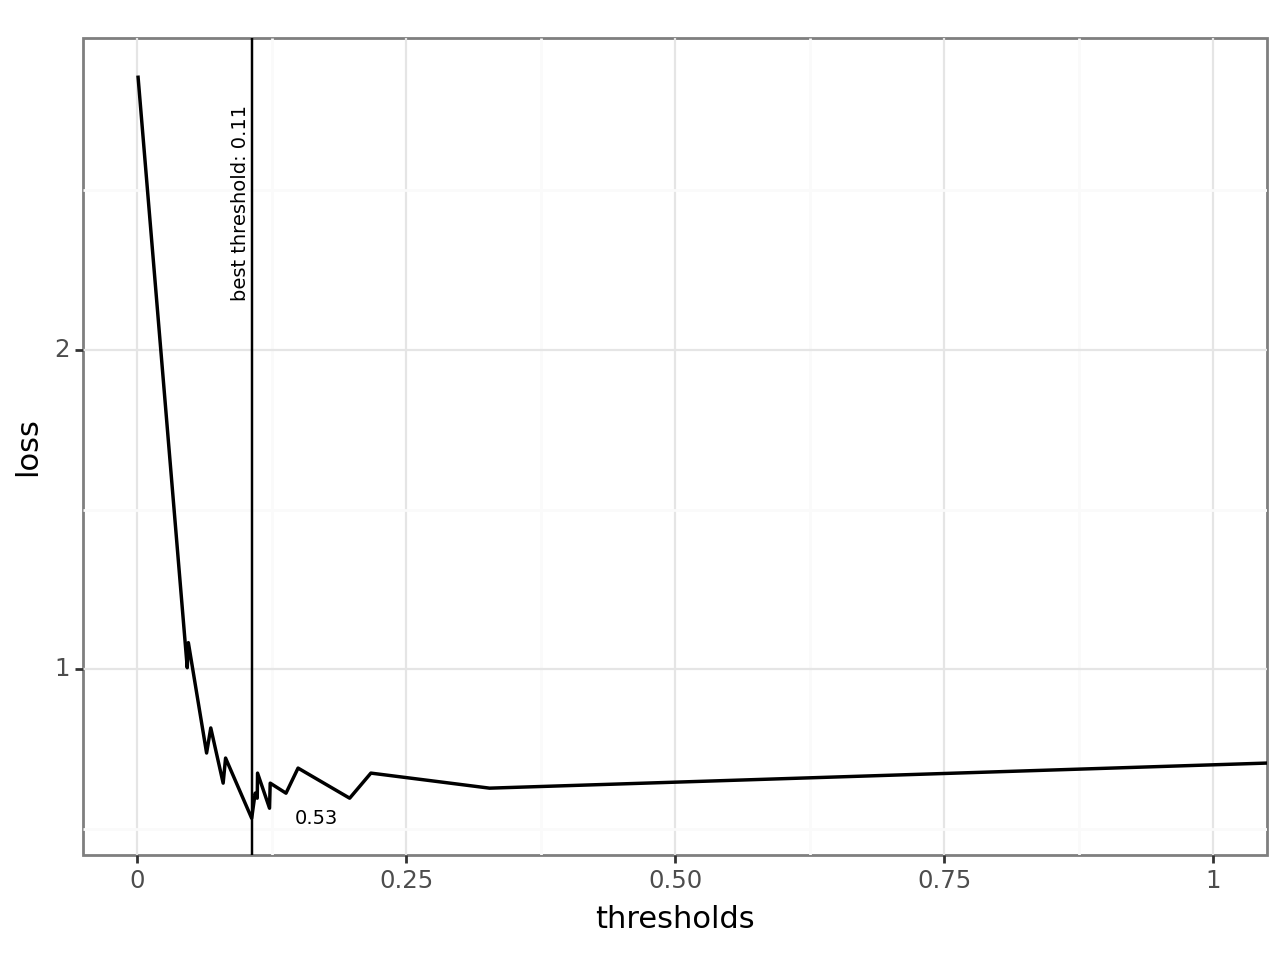

<Figure Size: (640 x 480)>

In [124]:
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

In [125]:
best_thresholds_cv

{'X1': inf, 'X2': inf, 'X3': 0.23765278995397657, 'rf_p': inf}

## Modeling on data2

In [126]:
ind2_catmat = patsy.dmatrix("0 + C(ind2)",dataset2, return_type="dataframe")
ind2_catmat = ind2_catmat.drop(['C(ind2)[1.0]'], axis=1)

In [127]:
ind_catmat = patsy.dmatrix("0 + C(ind)",dataset2, return_type="dataframe")
ind_catmat = ind_catmat.drop(['C(ind)[1.0]'], axis=1)

In [128]:
m_region_locmat = patsy.dmatrix("0 + C(region_m)",dataset2, return_type="dataframe")
m_region_locmat = m_region_locmat.drop(['C(region_m)[Central]'], axis=1)

In [129]:
urban_mmat = patsy.dmatrix("0 + C(urban_m)",dataset2, return_type="dataframe")
urban_mmat = urban_mmat.drop(['C(urban_m)[1.0]'], axis=1)

In [130]:
gender_catmat = patsy.dmatrix("0 + C(gender)",dataset2, return_type="dataframe")
gender_catmat = gender_catmat.drop(['C(gender)[male]'], axis=1)

In [131]:
origin_catmat = patsy.dmatrix("0 + C(origin)",dataset2, return_type="dataframe")
origin_catmat = origin_catmat.drop(['C(origin)[Domestic]'], axis=1)

In [132]:
raw = dataset2[raw_vars]
fin = dataset2[fin_vars]
X1 = pd.concat([raw, fin], axis=1)

In [133]:
X2 = pd.concat([X1, ind2_catmat, ind_catmat, m_region_locmat, urban_mmat, gender_catmat, origin_catmat], axis=1)

In [134]:
hr = dataset2[hr_vars]
X3 = pd.concat([X1, X2, hr], axis = 1)

In [135]:
rfvars  = pd.concat([X1, X2, hr], axis=1)

In [136]:
y = dataset2['default']

In [137]:
# definint train-holdout split based on dataset1's setup

index_train = data2.index
index_holdout = holdout_data.index

y_train = y.loc[index_train]
y_holdout = y.loc[index_holdout]

In [138]:
# specifying cross-validation 
k = KFold(n_splits = 5, shuffle = True, random_state = 20240224)

In [139]:
# no regularisation needed so setting the paremeter to very high value
Cs_value_logit = [1e20]

In [140]:
logit_model_vars = [X1.loc[index_train], X2.loc[index_train], X3.loc[index_train]]

logit_models = dict()
CV_RMSE_folds = dict()

In [141]:
%%time
for i in range(len(logit_model_vars)):
    LRCV_brier = LogisticRegressionCV(
        Cs=Cs_value_logit, 
        cv=k,
        refit=True, 
        scoring='neg_brier_score', 
        solver="newton-cg", 
        tol=1e-7, 
        random_state=20240224)
    logit_models['X'+str(i+1)] = LRCV_brier.fit(logit_model_vars[i], y_train)
    
    # Calculate RMSE on test for each fold
    CV_RMSE_folds['X'+str(i+1)] = np.sqrt(-1*(logit_models['X'+str(i+1)].scores_[1])).flatten()

CPU times: total: 1min 41s
Wall time: 1min 41s


In [142]:
# checking AUC scores as well
CV_AUC_folds = dict()

for i in range(len(logit_model_vars)):
    LRCV_auc = LogisticRegressionCV(
        Cs=Cs_value_logit, 
        cv=k, 
        refit=True, 
        scoring='roc_auc', 
        solver="newton-cg", 
        tol=1e-7, 
        random_state = 20240205)
    LRCV_auc_fit = LRCV_auc.fit(logit_model_vars[i], y_train)
    # Calculate AUC on test for each fold
    CV_AUC_folds['X'+str(i+1)] = LRCV_auc_fit.scores_[1][:,0].tolist()

In [143]:
pd.DataFrame(CV_AUC_folds)

,X1,X2,X3
0,0.738995,0.744232,0.732350
1,0.726883,0.726280,0.730189
2,0.725825,0.706200,0.713456
3,0.762633,0.782297,0.760192
4,0.725662,0.727178,0.734734


In [144]:
CV_RMSE = dict()
CV_AUC = dict()

for key in logit_models:
    CV_RMSE[key] = np.mean(CV_RMSE_folds[key])
    CV_AUC[key] = np.mean(CV_AUC_folds[key])  

logit_summary2 = np.transpose(pd.DataFrame.from_dict([CV_RMSE,CV_AUC], orient='columns'))
logit_summary2.columns = ['CV RMSE', 'CV AUC']
logit_summary2

,CV RMSE,CV AUC
X1,0.291934,0.736000
X2,0.292085,0.737237
X3,0.290577,0.734184


In dataset2, the models perform very similarily. Given that X1 is the simplest, and its RMSE and AUC scores are a close 2nd, this will be the preferred choice.

In [145]:
best_model = logit_models['X1']
best_model_X_holdout = X1.loc[index_holdout]

logit_predicted_probabilities_holdout = best_model.predict_proba(best_model_X_holdout)[:,1]
best_rmse_holdout = np.sqrt(metrics.mean_squared_error(y_holdout, logit_predicted_probabilities_holdout))
round(best_rmse_holdout, 3)

0.226

In [146]:
thresholds = [i/100 for i in range(1,80,1)]
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(logit_predicted_probabilities_holdout < thr, 0, 1)
    cm_thr = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp/(tp+fn))
    false_positive_rates.append(fp/(fp+tn))

In [147]:
cm_thr

array([[978,   3],
       [ 55,   1]], dtype=int64)

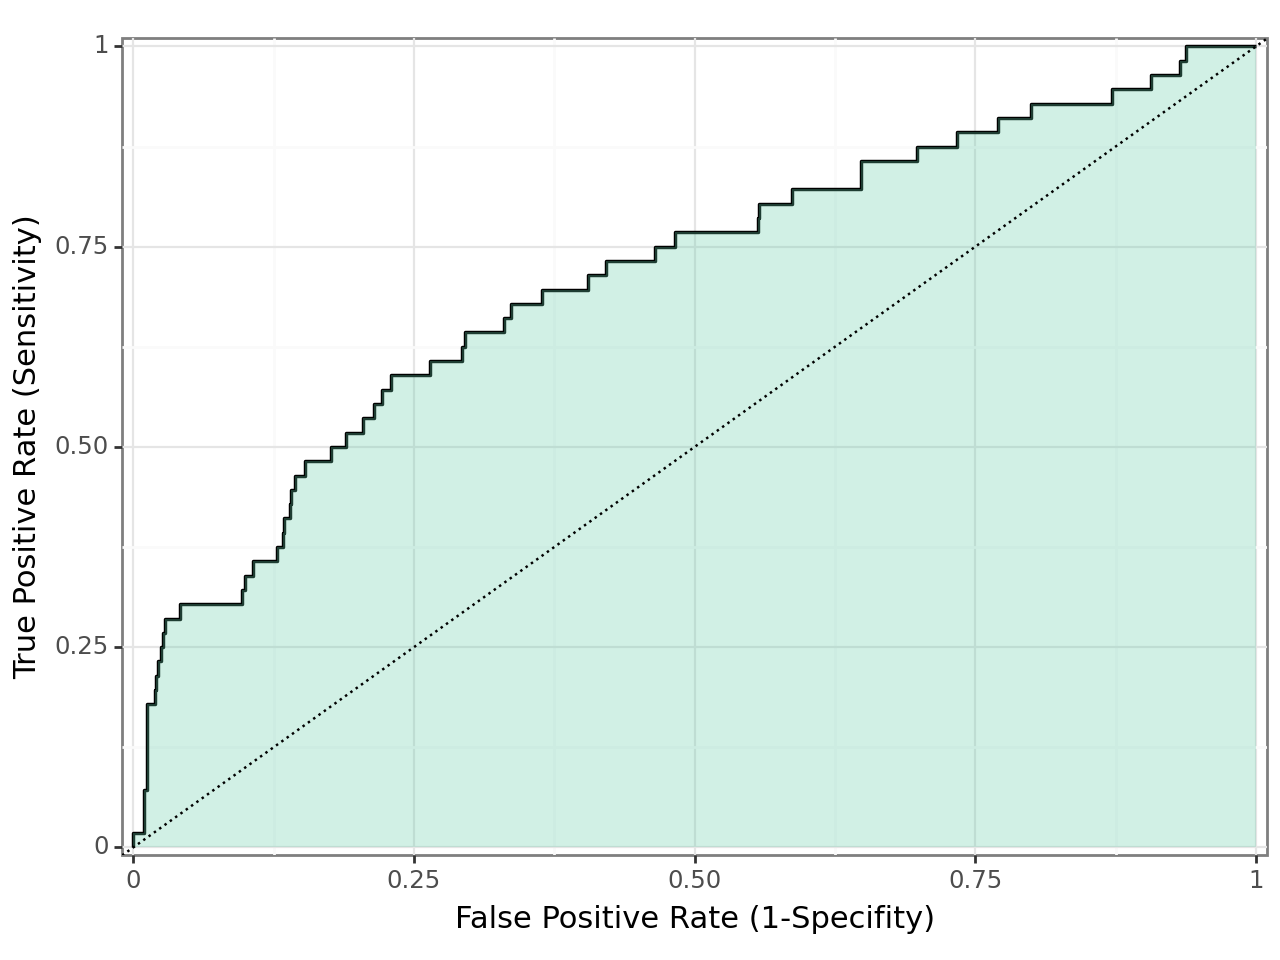

<Figure Size: (640 x 480)>

In [148]:
create_roc_plot(y_holdout, logit_predicted_probabilities_holdout)

### Using the loss function to define optimal threshold

In [149]:
FP = 3
FN = 15
cost = FN/FP

# the prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))
prevelance = y_train.sum()/len(y_train)
prevelance

0.09990274475902312

In [150]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss =[]
    if model_name != 'LASSO':
        X = logit_model_vars[i]
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index,:]
        y_fold = y_train.iloc[test_index]
        pred_fold = generate_fold_prediction(logit_models[model_name], X_fold, fold, c_index)
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(list(zip(
            np.abs(true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)),\
                                       thresholds)), key=lambda i: i[0], reverse=True)[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
        curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold+1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame({
        'false_pos': false_pos_rate*sum(y_fold == 0),
        'true_pos': true_pos_rate*sum(y_fold == 1),
        'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
        'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
        'pos': sum(y_fold == 1),
        'neg': sum(y_fold == 0),
        'n': len(y_fold),
        'thresholds': thresholds
    })
    
    fold5_all_coords[model_name] = all_coords

In [151]:
logit_summary3 = pd.DataFrame(best_thresholds_cv.items(),columns=['Model', 'Avg of optimal thresholds'])
logit_summary3['Threshold for Fold5'] = fold5_threshold.values()
logit_summary3['Avg expected loss'] = expected_loss_cv.values()
logit_summary3['Expected loss for Fold5'] = fold5_expected_loss.values()
logit_summary3

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,X1,0.128924,0.133710,1.193641,1.221562
1,X2,0.128374,0.134236,1.195260,1.211024
2,X3,0.142741,0.133463,1.192992,1.203729


In [152]:
best_logit_optimal_treshold = best_thresholds_cv["X3"]
best_logit_optimal_treshold

0.1427406692560245

In [153]:
holdout_treshold = np.where(logit_predicted_probabilities_holdout < best_logit_optimal_treshold, 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]).ravel()
expected_loss_holdout_log2 = (fp*FP + fn*FN)/len(y_holdout)
round(expected_loss_holdout_log2, 3)

0.691

Dataset2 manages to produce lower expected loss value (0.691) on the holdout set than dataset1 (0.749).

In [154]:
cm_object4 = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1])
cm4 = pd.DataFrame(cm_object4, 
    index=['Actul no defaul', 'Actual default'], 
    columns=['Predicted no default', 'Predicted default'])
cm4

,Predicted no default,Predicted default
Actul no defaul,937,44
Actual default,39,17


### Random forest

In [155]:
rfvars_train = rfvars.loc[index_train]
rfvars_holdout = rfvars.loc[index_holdout]

In [156]:
grid = {'max_features': [5, 6, 7],
        'criterion':['gini'],
        'min_samples_split': [11, 16]}

In [157]:
prob_forest = RandomForestClassifier(
    random_state=20240224, 
    n_estimators=500, 
    oob_score=True)

prob_forest_grid = GridSearchCV(
    prob_forest, 
    grid, 
    cv=k, 
    refit='roc_auc',
    scoring = ['accuracy', 'roc_auc', 'neg_brier_score'], 
    n_jobs=-1)

In [158]:
%%time
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

CPU times: total: 44.9 s
Wall time: 3min 34s


In [159]:
prob_forest_cv_results = pd.DataFrame({
    'max_features': prob_forest_fit.cv_results_['param_max_features'],
    'min_samples_split': prob_forest_fit.cv_results_['param_min_samples_split'],
    'cv_accuracy': cv_accuracy,
    'cv_auc': cv_auc,
    'cv_rmse': cv_rmse
})
prob_forest_cv_results

,max_features,min_samples_split,cv_accuracy,cv_auc,cv_rmse
0,5,11,0.951832,0.718711,0.209374
1,5,16,0.951832,0.723542,0.209350
2,6,11,0.951832,0.709432,0.210081
3,6,16,0.951832,0.721162,0.209361
4,7,11,0.951832,0.718785,0.210186
5,7,16,0.951832,0.713840,0.209817


In [160]:
best_max_features = prob_forest_fit.best_params_['max_features']
best_min_sample_split = prob_forest_fit.best_params_['min_samples_split']

In [161]:
print(f'The best random forest model has the following features: {prob_forest_fit.best_params_}')

The best random forest model has the following features: {'criterion': 'gini', 'max_features': 5, 'min_samples_split': 11}


**Using loss function and search for best thresholds and expected loss over folds**

In [162]:
best_thresholds = list()
expected_loss = list()

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index,:]
    y_fold = y_train.iloc[test_index]
    
    X_fold_train = rfvars_train.iloc[train_index,:]
    y_fold_train = y_train.iloc[train_index]
    
    prob_forest_best = RandomForestClassifier(
        random_state=20240224, 
        n_estimators=500, 
        oob_score=True,
        criterion = 'gini', 
        max_features = best_max_features, min_samples_split = best_min_sample_split)
    
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:,1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)
                ),
                threshold
            )
        ), 
        key=lambda x: x[0], reverse=True)[0][1]
    
    best_thresholds.append(best_threshold)
    
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
    curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
    expected_loss.append(curr_exp_loss)

In [163]:
best_thresholds

[0.1399179101943808,
 0.19398999349463752,
 0.22234489780944905,
 0.2320515948190097,
 0.19941208038607425]

In [164]:
fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame({
    'false_pos': false_pos_rate*sum(y_fold == 0),
    'true_pos': true_pos_rate*sum(y_fold == 1),
    'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
    'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
    'pos': sum(y_fold == 1),
    'neg': sum(y_fold == 0),
    'n': len(y_fold),
    'thresholds': threshold
})

all_coords_rf

,false_pos,true_pos,false_neg,true_neg,pos,neg,n,thresholds
0,0.0,0.0,371.0,3330.0,371,3330,3701,inf
1,0.0,1.0,370.0,3330.0,371,3330,3701,0.881184
2,0.0,6.0,365.0,3330.0,371,3330,3701,0.795460
3,1.0,6.0,365.0,3329.0,371,3330,3701,0.786826
4,1.0,9.0,362.0,3329.0,371,3330,3701,0.760092
...,...,...,...,...,...,...,...,...
536,3127.0,370.0,1.0,203.0,371,3330,3701,0.005002
537,3177.0,370.0,1.0,153.0,371,3330,3701,0.004066
538,3177.0,371.0,0.0,153.0,371,3330,3701,0.004042
539,3325.0,371.0,0.0,5.0,371,3330,3701,0.000154


In [165]:
expected_loss_cv['rf_p'] = np.mean(expected_loss)
best_thresholds_cv['rf_p'] = np.mean(best_thresholds)

In [166]:
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_max_features) & 
    (prob_forest_cv_results.min_samples_split == best_min_sample_split)]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

In [167]:
rf_summary = pd.DataFrame(
    {'CV RMSE': [round(prob_forest_best_results.cv_rmse.values[0], 3)],
     'CV AUC': [round(prob_forest_best_results.cv_auc.values[0], 3)],
     'Avg of optimal thresholds': [round(best_thresholds_cv['rf_p'], 3)],
     'Threshold for Fold5': [round(best_threshold, 3)],
     'Avg expected loss': [round(expected_loss_cv['rf_p'], 3)],
     'Expected loss for Fold5': [round(curr_exp_loss, 3)]})

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.209,0.719,0.198,0.199,0.945,0.92


**Take model to holdout and estimate RMSE, AUC and expected loss**

In [168]:
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[:,1]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)

0.211

In [169]:
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)

0.845

In [170]:
holdout_treshold = np.where(rf_predicted_probabilities_holdout < best_thresholds_cv['rf_p'], 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]).ravel()
expected_loss_holdout_rf2 = (fp*FP + fn*FN)/len(y_holdout)
round(expected_loss_holdout_rf2, 3)

0.639

This random forest model performs with the lowest expected loss with 0.639.

In [174]:
k.split

<bound method _BaseKFold.split of KFold(n_splits=5, random_state=20240224, shuffle=True)>

In [181]:
roc_curve(y_fold, pred_fold)

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.00300300e-04,
        3.00300300e-04, 9.00900901e-04, 9.00900901e-04, 1.20120120e-03,
        1.20120120e-03, 1.50150150e-03, 1.50150150e-03, 1.80180180e-03,
        1.80180180e-03, 2.70270270e-03, 2.70270270e-03, 3.00300300e-03,
        3.00300300e-03, 3.30330330e-03, 3.30330330e-03, 3.60360360e-03,
        3.60360360e-03, 3.90390390e-03, 3.90390390e-03, 4.20420420e-03,
        4.20420420e-03, 5.10510511e-03, 5.10510511e-03, 5.40540541e-03,
        5.40540541e-03, 5.70570571e-03, 5.70570571e-03, 6.30630631e-03,
        6.30630631e-03, 7.20720721e-03, 7.20720721e-03, 7.50750751e-03,
        7.50750751e-03, 7.80780781e-03, 7.80780781e-03, 8.10810811e-03,
        8.10810811e-03, 8.40840841e-03, 8.40840841e-03, 9.00900901e-03,
        9.00900901e-03, 9.60960961e-03, 9.60960961e-03, 1.08108108e-02,
        1.08108108e-02, 1.11111111e-02, 1.11111111e-02, 1.14114114e-02,
        1.14114114e-02, 1.17117117e-02, 1.17117117e-02, 1.261261